                                    IMAGE SEGMENTATION

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet', with_info=True)



import tensorflow_datasets as tfds
→ This imports the tensorflow_datasets library, which gives you access to many ready-to-use datasets.

tfds.load('oxford_iiit_pet', with_info=True)
→ Downloads the Oxford IIIT Pet dataset
→ Splits it into 'train' and 'test'
→ Also returns info, which contains details like number of images, labels, etc.

You now have:

dataset['train'] → training images and masks

dataset['test'] → test images and masks

info → extra information about the dataset

In [3]:
print(info)


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

In [9]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask


This defines a function called resize.
It takes in two inputs:

input_image — your actual image (like a pet or object photo), and

input_mask — the corresponding segmentation mask (which shows what part of the image belongs to which class, like "cat" vs. "background").
 This line resizes the input image to 128x128 pixels.
 The method="nearest" means it uses the nearest neighbor algorithm to resize, which is fast and simple.
 It's usually used when you don't want to introduce any blur — useful for masks or simple images.
  Same as above, but this line resizes the segmentation mask.
 Since masks are made of class labels (0, 1, 2, etc.), we use "nearest" to avoid changing those values.
 For example, if a mask pixel is 1 (say, "cat"), we don't want it to become 0.5 after resizing — "nearest" keeps it clean.After resizing, this line returns both the image and the mask, now resized to 128x128.

Why we use this:
Before feeding data into a neural network like U-Net, it's important that all images and masks are the same size — otherwise the model won't work properly.

Let me know if you want a visual example or how to use this function in your data pipeline!

In [10]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask


In [11]:
from tensorflow.keras import layers, models
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

 Defining a new function called normalize.
It takes two things as input:

input_image: your image (with pixel values from 0 to 255),

input_mask: the segmentation mask (with class labels like 1, 2, 3, etc.).

python
Copy
Edit
   input_image = tf.cast(input_image, tf.float32) / 255.0
🔹 This converts the image pixels to float values between 0 and 1.
Why?
 Neural networks learn better when input values are small and in a common range (like 0 to 1).
 tf.cast(..., tf.float32) changes the image from integers to floating point numbers.
/ 255.0 scales down pixel values from [0, 255] to [0, 1].

   input_mask -= 1
🔹 This reduces each value in the mask by 1.
Why?
 Often, segmentation masks have values like 1, 2, 3 for different classes.
 But many models (like U-Net with sparse_categorical_crossentropy) expect class labels starting from 0.
So, this line shifts the range from [1, 2, 3] to [0, 1, 2].
   return input_image, input_mask
 Finally, the function returns the normalized image and adjusted mask, ready to go into your model.

Summary in one line:
 This function prepares your image and mask data so that the neural network can train smoothly.

Let me know if you want to see how to use this inside your map() function in a TensorFlow dataset!

In [12]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

This function is used to load and process a training image and its mask.


def load_image_train(datapoint):
defining a function that takes one input: datapoint, which is a dictionary with:

"image": the input image

"segmentation_mask": the corresponding mask for segmentation


   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
extracting the image and the segmentation mask from the datapoint.


   input_image, input_mask = resize(input_image, input_mask)
   resizing both the image and mask to a standard size (128x128).
This makes sure all inputs are the same shape for the model.

   input_image, input_mask = augment(input_image, input_mask)
This applies data augmentation like flipping or rotating.
 Helps the model generalize better by showing it slightly varied versions of the data.


   input_image, input_mask = normalize(input_image, input_mask)
This:

Scales the image pixels to [0, 1]

Adjusts the mask so that labels start from 0 instead 1
   return input_image, input_mask
   Finally, returns the processed image and mask ready for training.

 load_image_test(datapoint)
This is the testing version, used when you don’t want to augment.


def load_image_test(datapoint):

   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
Same as before: extract image and mask.


   input_image, input_mask = resize(input_image, input_mask)
 Resize to 128x128.


   input_image, input_mask = normalize(input_image, input_mask)
🔹 Normalize image and adjust mask values.

In [13]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

dataset["train"]
This accesses the training portion of your dataset (usually from tensorflow_datasets or a custom split).

🔹 .map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
This applies the function load_image_train to every item in the training dataset.

It's like saying: “for each image-mask pair, apply my resizing, augmentation, and normalization.”

🔹 num_parallel_calls=tf.data.AUTOTUNE
This tells TensorFlow to automatically figure out how many CPU threads to use for loading data in parallel, making training faster and more efficient 🚀.

✅ Same thing is done for test_dataset, except it uses load_image_test which doesn't include augmentation (because test data should stay unchanged).

🧠 Why it's important:
This setup ensures each image is correctly preprocessed before being fed into the model.

It uses parallel processing to speed up the data loading and improve performance.

In [14]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

BATCH_SIZE = 64: Number of samples the model sees before updating weights.

BUFFER_SIZE = 1000: Number of elements to load and randomly shuffle from when shuffling.

🔄 Train Batches:
python
Copy
Edit
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
What this does:
cache(): Keeps the dataset in memory (after first epoch), speeding up training.

shuffle(BUFFER_SIZE): Shuffles the dataset to help the model learn better.

batch(BATCH_SIZE): Groups 64 examples together into one batch.

repeat(): Repeats the dataset forever (you’ll stop training manually by defining steps_per_epoch).

prefetch(): Allows the next batch to be prepared while the current one is being used — improving training speed.

✅ Validation Batches:
python
Copy
Edit
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
Uses the first 3000 samples from test_dataset for validation.

batch() groups them into batches of 64.

🧪 Test Batches:
python
Copy
Edit
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)
Skips the first 3000 samples and uses the next 669 for testing.

Batches them for evaluation.

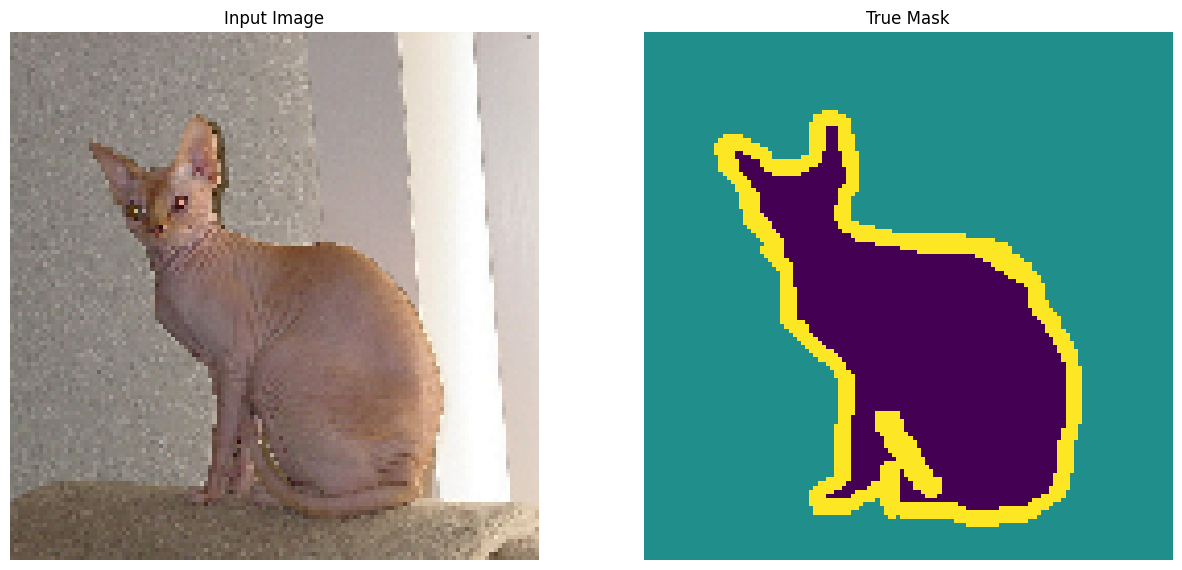

In [16]:
import numpy as np
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [17]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

This function takes an input tensor x (like an image or feature map) and applies two convolutional layers.

n_filters is the number of filters (output channels) to use — like 64, 128, etc.

🧱 What Happens Inside:
python
Copy
Edit
x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
Conv2D applies a 3x3 convolution with n_filters (e.g., 64 filters) to detect patterns.

padding="same" keeps the size of the image the same (no shrinking).

activation="relu" adds non-linearity so the model can learn complex patterns.

kernel_initializer="he_normal" is a smart way to initialize weights — it helps speed up learning.

Then you do the same step again:

python
Copy
Edit
x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
🧠 Why Two Convolutions?
Using two conv layers instead of one helps the model learn richer features.

This is especially helpful in segmentation tasks where detail matters.

✅ Example:
If you pass in an image with shape (128, 128, 3) and n_filters = 64, you’ll get:

Output shape → (128, 128, 64)

It will have learned 64 different feature maps.

In [18]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

Takes in an input x (image or feature map).

Applies convolution to extract features, and reduces the size of the feature map.

Returns:

f: features to be used later for skip connections.

p: the pooled (downsampled) version passed deeper into the network.

🔍 Line-by-line Breakdown:
python
Copy
Edit
f = double_conv_block(x, n_filters)
This applies two convolution layers to learn detailed features from input x.

f contains these feature maps (used later in the decoder for skip connections).

python
Copy
Edit
p = layers.MaxPool2D(2)(f)
This is a max pooling layer that reduces the spatial size (height and width) by half.

It helps the network understand higher-level features and reduces computation.

python
Copy
Edit
p = layers.Dropout(0.3)(p)
This randomly drops 30% of the connections to prevent overfitting.

Useful when training on limited data to improve generalization.

🧠 Why Return f and p?
f is saved to connect later during upsampling (skip connections help the model retain fine details).

p is passed deeper down to the next level in the encoder.

✅ Example:
If x is of shape (128, 128, 3) and n_filters = 64:

f → (128, 128, 64) (after 2 convs)

p → (64, 64, 64) (after max pooling)

This is an essential part of U-Net. Once you complete the decoder blocks (upsampling), your segmentation model will be ready to train and test.

In [19]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

Inputs:

x: current feature map from the previous decoder layer.

conv_features: saved features from the encoder (for skip connections).

n_filters: number of filters to use in convolution layers.

Returns: a feature map with restored spatial dimensions and combined details from encoder + decoder.

🧠 Line-by-Line Explanation:
python
Copy
Edit
x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
Performs upsampling (opposite of max pooling).

Increases the size of the feature map (e.g., from 16×16 to 32×32).

Conv2DTranspose not only increases size but also learns how to do it.

python
Copy
Edit
x = layers.concatenate([x, conv_features])
Skip connection: combines upsampled features with matching features from the encoder.

Helps the model retain fine-grained details lost during downsampling.

python
Copy
Edit
x = layers.Dropout(0.3)(x)
Regularization step: drops 30% of connections randomly to avoid overfitting.

python
Copy
Edit
x = double_conv_block(x, n_filters)
Applies two convolution layers (like in the encoder) to learn better representations at this upsampled level.

✅ Why This Block Matters:
Helps the U-Net progressively restore the input image size.

Combines coarse semantic features with fine spatial details using skip connections.

📐 Example:
If x is (32, 32, 512) and conv_features is (32, 32, 512):

After transpose conv → (64, 64, 256)

After concatenation → (64, 64, 512 + 256)

Final output after convs → (64, 64, 256)

In [23]:
 # inputs
def build_unet_model():
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

This function builds and returns the U-Net model for image segmentation using the Keras Functional API.

🟢 Step 1: Define the Input
python
Copy
Edit
inputs = layers.Input(shape=(128,128,3))
Takes an image of shape 128×128 with 3 color channels (RGB).

Acts as the entry point for your model.

🔽 Step 2: Encoder (Contracting Path)
This path extracts features while reducing spatial dimensions.

python
Copy
Edit
f1, p1 = downsample_block(inputs, 64)
f2, p2 = downsample_block(p1, 128)
f3, p3 = downsample_block(p2, 256)
f4, p4 = downsample_block(p3, 512)
Each downsample block:

Applies two Conv2D layers (via double_conv_block).

Uses MaxPooling and Dropout for downsampling + regularization.

f1, f2, ... are feature maps used later in skip connections.

p4 is the smallest spatial representation.

💡 Step 3: Bottleneck
python
Copy
Edit
bottleneck = double_conv_block(p4, 1024)
Deepest layer of the U-Net.

Captures the most abstract and powerful features.

🔼 Step 4: Decoder (Expanding Path)
This path upsamples the feature maps and combines them with the encoder features to recover spatial info.

python
Copy
Edit
u6 = upsample_block(bottleneck, f4, 512)
u7 = upsample_block(u6, f3, 256)
u8 = upsample_block(u7, f2, 128)
u9 = upsample_block(u8, f1, 64)
Uses Conv2DTranspose to upsample.

Merges with encoder features using skip connections.

Applies two more Conv2D layers (via double_conv_block) after each upsample.

🎯 Step 5: Output Layer
python
Copy
Edit
outputs = layers.Conv2D(3, 1, padding="same", activation="softmax")(u9)
A 1×1 convolution to project to 3 channels (number of segmentation classes).

Uses softmax for multi-class segmentation.

🧠 Final Model
python
Copy
Edit
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
Combines all layers into a Keras Model object.

🔁 Return the Model
python
Copy
Edit
return unet_model
✅ Summary of Architecture:
Encoder: Downsampling to capture features.

Bottleneck: Deep features.

Decoder: Upsampling with skip connections to reconstruct the segmented image.

Output: Segmentation map with 3 classes.

In [24]:
unet_model = build_unet_model()

In [26]:
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]  # Wrap in square brackets
)


In [28]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8957 - loss: 0.2683 - val_accuracy: 0.8749 - val_loss: 0.3380
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9000 - loss: 0.2573 - val_accuracy: 0.8734 - val_loss: 0.3500
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8965 - loss: 0.2667 - val_accuracy: 0.8821 - val_loss: 0.3318
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9046 - loss: 0.2434 - val_accuracy: 0.8843 - val_loss: 0.3173
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9078 - loss: 0.2346 - val_accuracy: 0.8880 - val_loss: 0.3209
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9084 - loss: 0.2334 - val_accuracy: 0.8809 - val_loss: 0.3298
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9059 - loss: 0.2415 - val_accuracy: 0.8843 - val_loss: 0.3445
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9093 - loss: 0.2322 - val_accuracy: 0.8851 - val_loss:

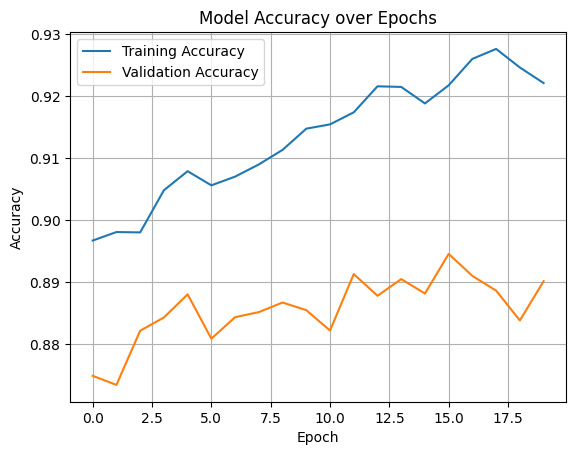

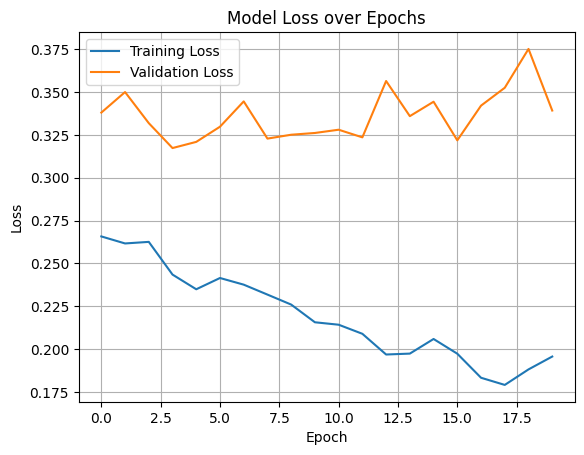

In [30]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



In [31]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 11


In [32]:
import matplotlib.pyplot as plt

def display(display_list):
    plt.figure(figsize=(15, 5))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step


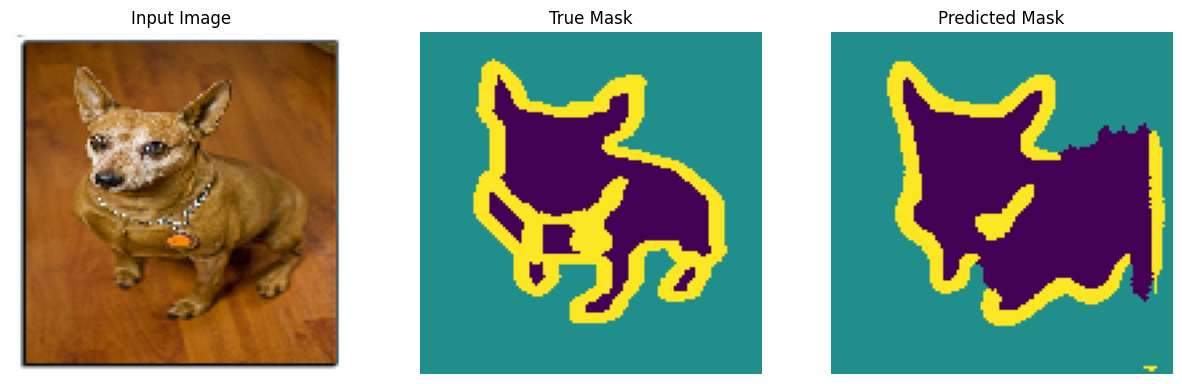

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


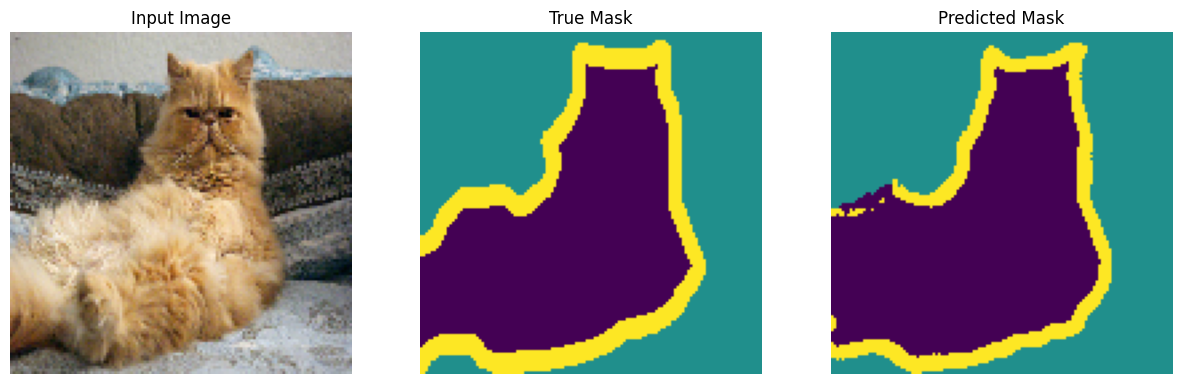

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


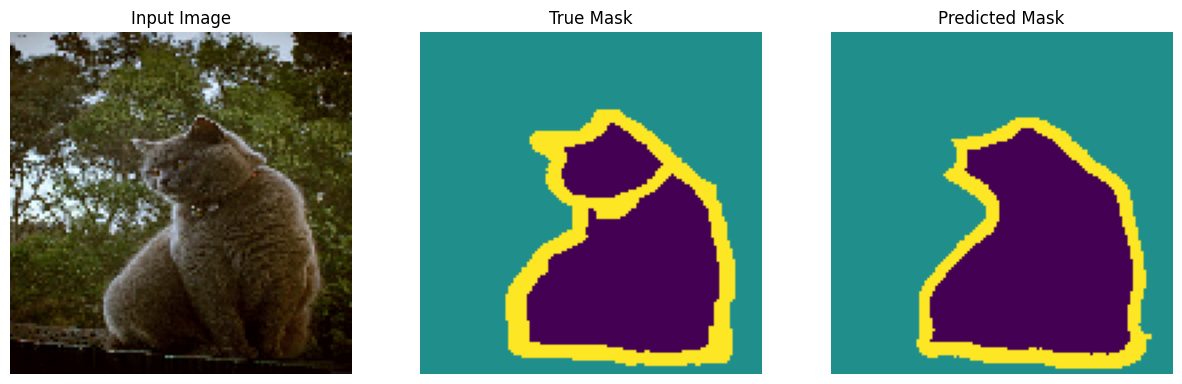

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


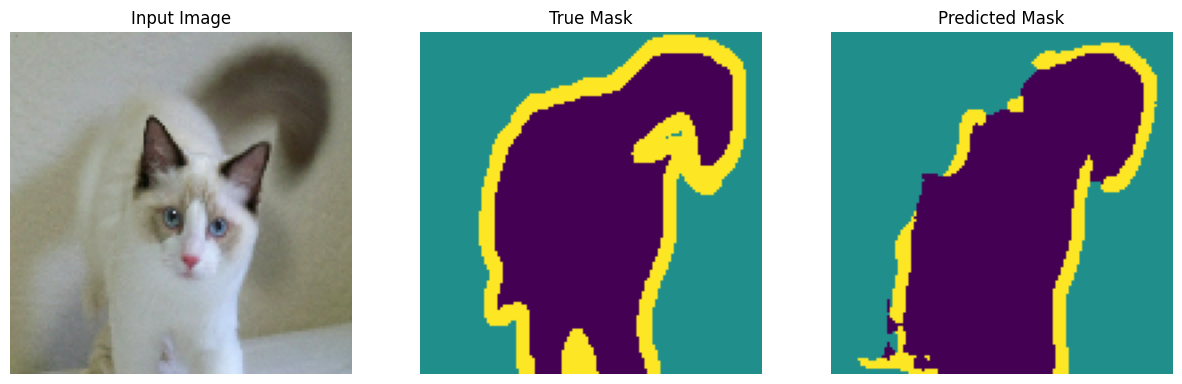

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


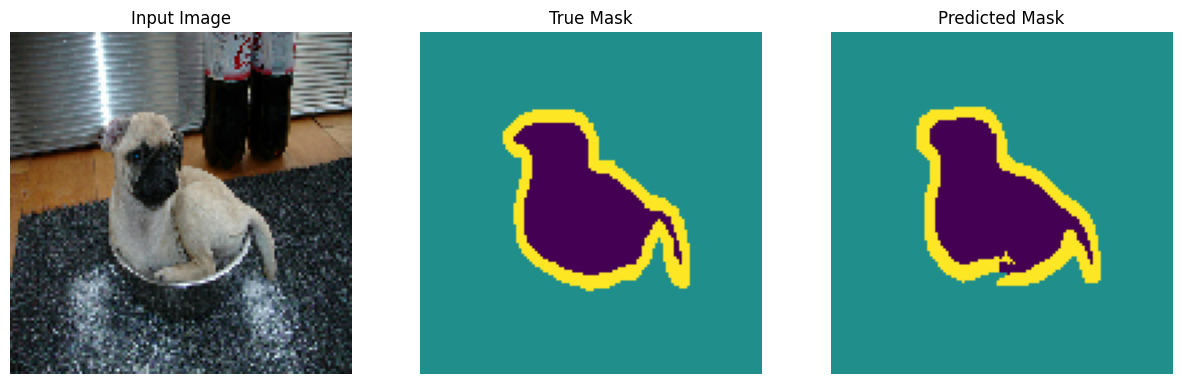

In [33]:
# Show 5 sample predictions from test data
show_predictions(dataset=test_batches, num=5)


In [36]:
unet_model.save("unet_pet_segmentation.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("unet_pet_segmentation.h5", compile=False)

# Compile it again if you want to train or evaluate
loaded_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
